In [2]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
from tensorflow.keras.layers import Add, BatchNormalization, Conv2D, Dense, Flatten, Input, LeakyReLU, PReLU, Lambda, MaxPool2D, ReLU
from tensorflow.keras.models import Model

In [7]:
def res_block_simple(inp, stage, substage):    
    filters=inp.shape.as_list()[-1]//4
    conv=Conv2D(filters, 1, activation='relu', use_bias=False, name='res{0}{1}_branch2a'.format(stage, substage))(inp)   
    conv=Conv2D(filters, 3, padding='same', activation='relu', use_bias=False, name='res{0}{1}_branch2b'.format(stage, substage))(conv)
    conv=Conv2D(filters*4, 1, activation='relu', use_bias=False, name='res{0}{1}_branch2c'.format(stage, substage))(conv)    
    add=Add(name='res{0}{1}_'.format(stage, substage))([inp, conv])
    return ReLU(name='res{0}{1}'.format(stage, substage))(add)

def res_block_ext(inp, stage):    
    filters=inp.shape.as_list()[-1]//2
    strds=(2,2)
    if filters==32:
        filters=filters*2
        strds=(1,1)        
    conv=Conv2D(filters, 1, strides=strds, activation='relu', use_bias=False, name='res{0}a_branch2a'.format(stage))(inp)    
    conv=Conv2D(filters, 3, padding='same', activation='relu', use_bias=False, name='res{0}a_branch2b'.format(stage))(conv)     
    conv=Conv2D(filters*4, 1, use_bias=False, name='res{0}a_branch2c'.format(stage))(conv)    
    inp1=Conv2D(filters*4, 1, strides=strds, use_bias=False, name='res{0}a_branch1'.format(stage))(inp)    
    
    add=Add(name='res{0}a_'.format(stage))([conv,inp1])
    return ReLU(name='res{0}a'.format(stage))(add)

def get_res50(inp_shape=(500,500,3)):
    inp=Input(shape=inp_shape)
    conv=Conv2D(64, 7, padding='same', activation='relu', name='conv1')(inp)    
    out=MaxPool2D(strides=2, name='pool1')(conv)    
    outputs=[conv]
    
    for num, blocks in enumerate([2,3,5,2]):
        stage=num+2
        out=res_block_ext(out, stage)
        for substage in 'bcdef'[:blocks]:
            out=res_block_simple(out, stage, substage)
        outputs.append(out)
    return Model(inputs=inp,outputs=outputs)

In [8]:
mod=get_res50()
for lr in mod.weights:
    print('{0:20} {1}'.format(lr.name.split('/')[0], lr.shape))

conv1_1              (7, 7, 3, 64)
conv1_1              (64,)
res2a_branch2a_1     (1, 1, 64, 64)
res2a_branch2b_1     (3, 3, 64, 64)
res2a_branch2c_1     (1, 1, 64, 256)
res2a_branch1_1      (1, 1, 64, 256)
res2b_branch2a_1     (1, 1, 256, 64)
res2b_branch2b_1     (3, 3, 64, 64)
res2b_branch2c_1     (1, 1, 64, 256)
res2c_branch2a_1     (1, 1, 256, 64)
res2c_branch2b_1     (3, 3, 64, 64)
res2c_branch2c_1     (1, 1, 64, 256)
res3a_branch2a_1     (1, 1, 256, 128)
res3a_branch2b_1     (3, 3, 128, 128)
res3a_branch2c_1     (1, 1, 128, 512)
res3a_branch1_1      (1, 1, 256, 512)
res3b_branch2a_1     (1, 1, 512, 128)
res3b_branch2b_1     (3, 3, 128, 128)
res3b_branch2c_1     (1, 1, 128, 512)
res3c_branch2a_1     (1, 1, 512, 128)
res3c_branch2b_1     (3, 3, 128, 128)
res3c_branch2c_1     (1, 1, 128, 512)
res3d_branch2a_1     (1, 1, 512, 128)
res3d_branch2b_1     (3, 3, 128, 128)
res3d_branch2c_1     (1, 1, 128, 512)
res4a_branch2a_1     (1, 1, 512, 256)
res4a_branch2b_1     (3, 3, 256, 256)
re

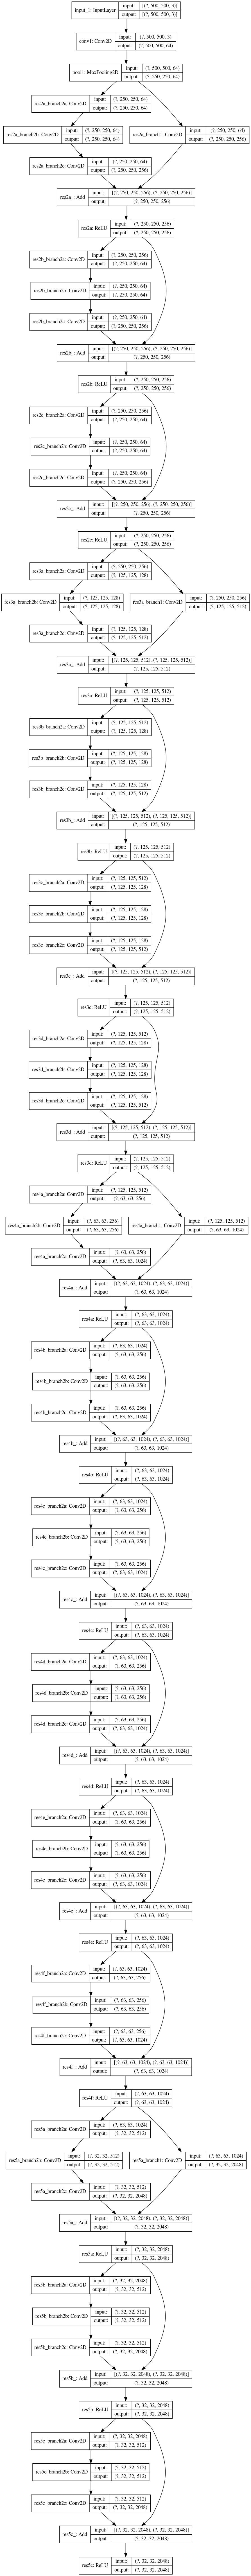

In [6]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(mod, to_file=dot_img_file, show_shapes=True)

In [9]:
mod.output

[<tf.Tensor 'conv1_1/Identity:0' shape=(None, 500, 500, 64) dtype=float32>,
 <tf.Tensor 'res2c_1/Identity:0' shape=(None, 250, 250, 256) dtype=float32>,
 <tf.Tensor 'res3d_1/Identity:0' shape=(None, 125, 125, 512) dtype=float32>,
 <tf.Tensor 'res4f_1/Identity:0' shape=(None, 63, 63, 1024) dtype=float32>,
 <tf.Tensor 'res5c_1/Identity:0' shape=(None, 32, 32, 2048) dtype=float32>]

# Caffe section

In [ ]:
import caffe
import numpy as np
from PIL import Image
base=r'/home/sgr/COB/models'
PRETRAINED = '{0}/COB_PASCALContext_trainval.caffemodel'.format(base)
MODEL_FILE = '{0}/deploy.prototxt'.format(base)

img = np.asarray(Image.open(r'/home/sgr/Загрузки/COB/demos/2010_005731.png'))

net = caffe.Net(MODEL_FILE, PRETRAINED, caffe.TEST)
caffe.set_mode_cpu()

counter=0
for key in net.params:    
    num=net.params[key].__len__()
    out='{0:22}#{1:2}'.format(key, num)
    
    for i in range(num):
        sh=net.params[key][i].data[...].shape
#         out='{0}; {1:3} shape:{2:25}'.format(out, i, sh)
        out='{0};\t{1}: shape:{2:20}'.format(out, i+1, str(sh))
    counter+=1
    print(out)
print('Total params layer: '+str(counter))